# RESEGMENTATION PIPELINE

## Set up source and destination folders

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, box


In [4]:
ddir = 'D:\Alexis\Projects\SpatialOmics_cellpose\\results'
base_path = "D:\Alexis\Projects\SpatialOmics_cellpose\data5k\output-XETG00245__0041374__Section_1_1886OD__20250326__175738"

# Select first and third hannels for segmentation (can only select two) 
fullres_chanel_0 = f"{base_path}\morphology_focus\morphology_focus_0000.ome.tif"   
fullres_chanel_2 = f"{base_path}\morphology_focus\morphology_focus_0002.ome.tif"
sample_name = "1886od"
ROI_filepath = f"{base_path}\{sample_name}_coords.csv"

# Levels: pixelsize in µm https://kb.10xgenomics.com/hc/en-us/articles/11636252598925
scalefactors = {
    0: 0.2125,
    1: 0.4250,
    2: 0.85,
    3: 1.7,
    4: 3.4,
    5: 6.8,
    6: 13.6,
    7: 27.2,
}

# Define resolution level and crop size in pixels
level = 0
pixelsize = scalefactors[level]

# Define patch size
crop_size = 600/pixelsize

## Define the region of interest (ROI)

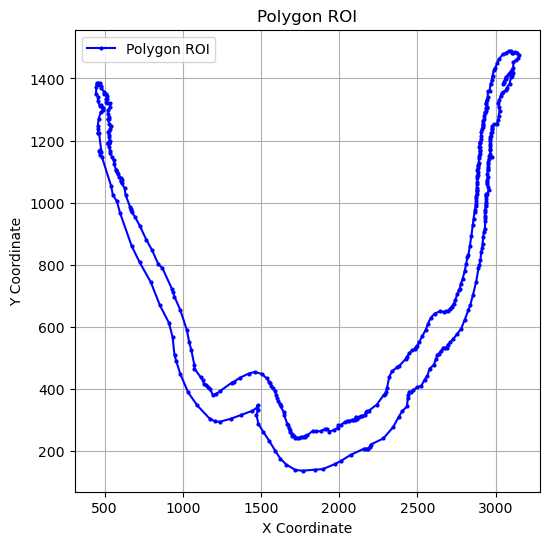

In [5]:
# Read the ROI coordinates from the CSV file
from SRC_RESEG.crop_image import *
plot_roi(ROI_filepath)
polygon_coords = pd.read_csv(ROI_filepath)
# Extract the X and Y coordinates
x_coords = polygon_coords['X']
y_coords = polygon_coords['Y']


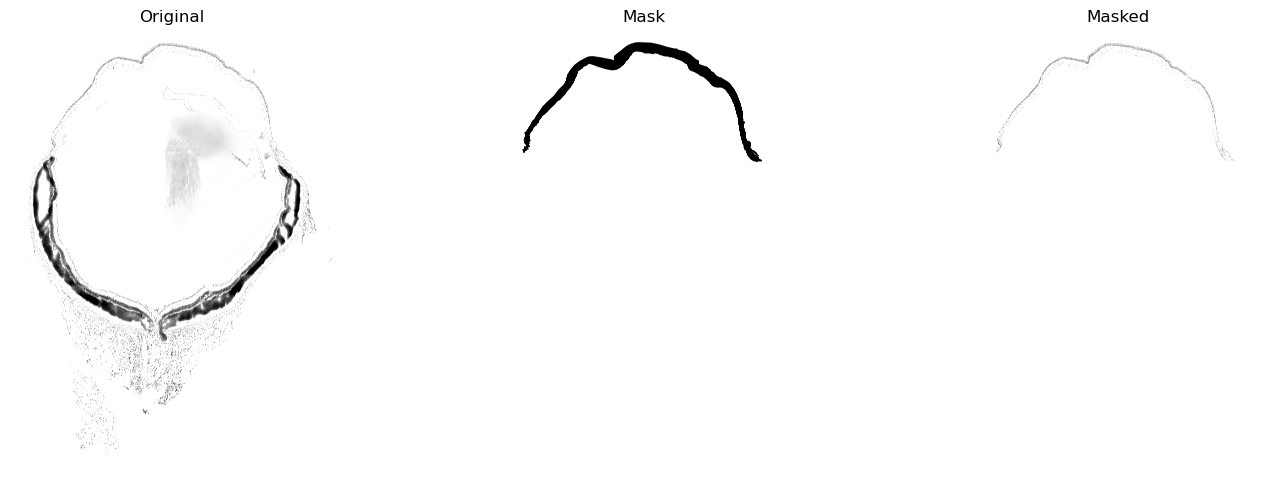

In [6]:
mask, masked_img_0 = mask_polygon_from_tif(
    fullres_chanel_0,
    x_coords, y_coords,
    scalefactors,
    level=0,
    plot=True
)

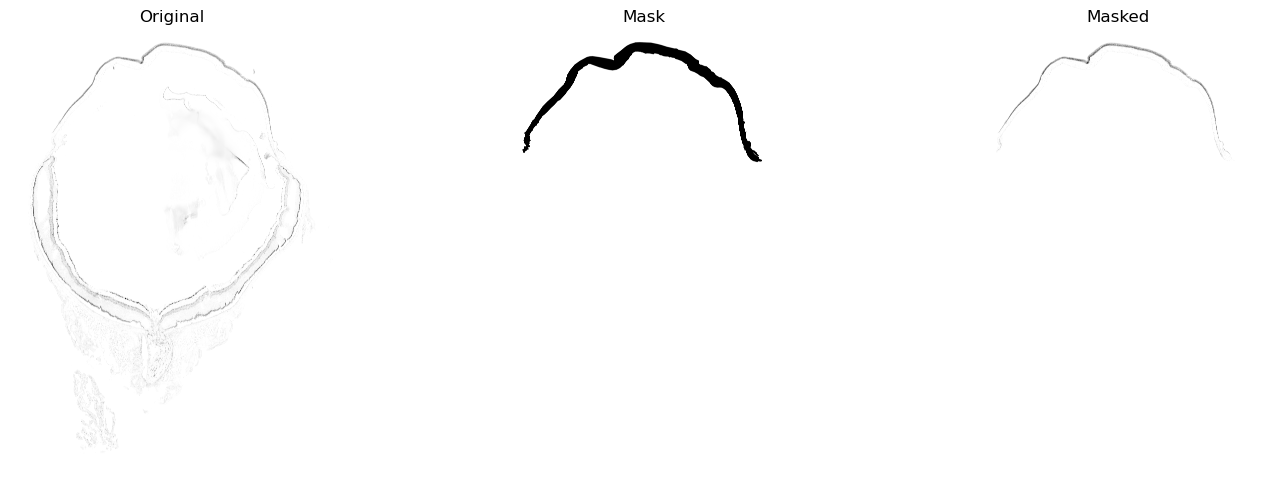

In [7]:
mask, masked_img_2 = mask_polygon_from_tif(
    fullres_chanel_2,
    x_coords, y_coords,
    scalefactors,
    level=0,
    plot=True
)

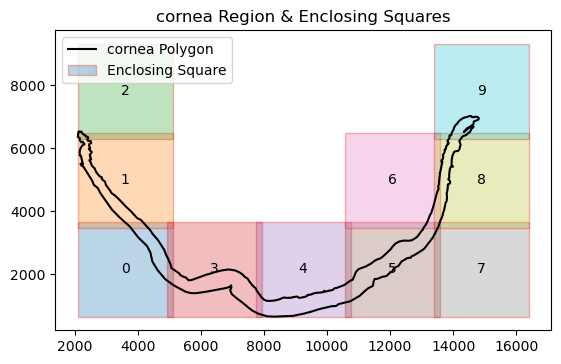

In [8]:
# Combine X and Y into coordinate pairs
x_coords_rescaled = x_coords / pixelsize
y_coords_rescaled = y_coords / pixelsize
rescaled_polygon_roi = list(zip(x_coords_rescaled, y_coords_rescaled))

# Create a Polygon object
rescaled_polygon_roi = Polygon(rescaled_polygon_roi)

# Define square size
square_size = int(crop_size)
overlap_size = 40/0.2125

# Generate non-overlapping square regions
overlapping_squares = crop_polygon_to_squares(rescaled_polygon_roi, square_size, overlap_size=overlap_size, with_overlap=True)
non_overlapping_squares = crop_polygon_to_squares(rescaled_polygon_roi, square_size, with_overlap=False)


plot_polygon_and_squares(
    rescaled_polygon_roi,
    overlapping_squares,
    title="cornea Region & Enclosing Squares",
    polygon_label="cornea Polygon",
    square_label="Enclosing Square"
)

# for square in overlapping_squares:
#     print("square:", square)
#     x, y = square.exterior.xy
#     print(" x:", x,"\n", "y:", y)


In [9]:
import os

In [10]:
# Process and plot the square regions
for i, square in enumerate(overlapping_squares):
    print(f"Processing square {i + 1}:", square)
    
    # ch 0 Crop the region 
    cropped_image_sub = crop_region(masked_img_0, square)
    # ch2 Crop the region
    cropped_image_sub2 = crop_region(masked_img_2, square)
    cropped_image_sub_combined = np.stack((cropped_image_sub, cropped_image_sub2), axis=0)


    # Check if the folder exists, if not create it
    save_dir = f"{ddir}/cropped_image/{sample_name}"
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
        print(f"Created directory: {save_dir}")

    # Save the cropped image
    save_path = f"{save_dir}/cropped_square_com_{i + 1}.tif"
    tifffile.imwrite(save_path, cropped_image_sub_combined)
    print(f"Cropped image saved to {save_path}")

Processing square 1: POLYGON ((5103.235294117647 645, 5103.235294117647 3656.235294117647, 2092 3656.235294117647, 2092 645, 5103.235294117647 645))
Created directory: D:\Alexis\Projects\SpatialOmics_cellpose\results/cropped_image/1886od
Cropped image saved to D:\Alexis\Projects\SpatialOmics_cellpose\results/cropped_image/1886od/cropped_square_com_1.tif
Processing square 2: POLYGON ((5103.235294117647 3468, 5103.235294117647 6479.235294117647, 2092 6479.235294117647, 2092 3468, 5103.235294117647 3468))
Cropped image saved to D:\Alexis\Projects\SpatialOmics_cellpose\results/cropped_image/1886od/cropped_square_com_2.tif
Processing square 3: POLYGON ((5103.235294117647 6291, 5103.235294117647 9302.235294117647, 2092 9302.235294117647, 2092 6291, 5103.235294117647 6291))
Cropped image saved to D:\Alexis\Projects\SpatialOmics_cellpose\results/cropped_image/1886od/cropped_square_com_3.tif
Processing square 4: POLYGON ((7926.235294117647 645, 7926.235294117647 3656.235294117647, 4915 3656.235

## CELLPOSE - SEGMENTATION

In [11]:
from SRC_RESEG.segmentation_cp import *




Welcome to CellposeSAM, cellpose v
cellpose version: 	4.0.4 
platform:       	win32 
python version: 	3.11.10 
torch version:  	2.7.1+cu126! The neural network component of
CPSAM is much larger than in previous versions and CPU excution is slow. 
We encourage users to use GPU/MPS if available. 




In [12]:
model = models.CellposeModel(gpu=True, 
                             pretrained_model='D:\Alexis\Projects\SpatialOmics_cellpose\models\cpsam_DED',
                             )

In [13]:
# Example usage
total = process_images_in_folder(
    input_folder = f'{ddir}/cropped_image/{sample_name}',      
    output_folder = f'{ddir}/segmenatation/{sample_name}',
    cellpose_model = model
)

print(f"Total cells detected: {total}")

channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


Processing file: cropped_square_com_1.tif, shape: (2, 3011, 3011)
Mask Segmentation Down!
Number of detected regions in cropped_square_com_1.tif: 196


channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


Segmentation output saved to 'segmented_output_seg.npy'
Output of [cropped_square_com_1.tif] saved as: D:\Alexis\Projects\SpatialOmics_cellpose\results/segmenatation/1886od\cropped_square_com_1

Processing file: cropped_square_com_10.tif, shape: (2, 3011, 3011)
Mask Segmentation Down!
Number of detected regions in cropped_square_com_10.tif: 102


channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


Segmentation output saved to 'segmented_output_seg.npy'
Output of [cropped_square_com_10.tif] saved as: D:\Alexis\Projects\SpatialOmics_cellpose\results/segmenatation/1886od\cropped_square_com_10

Processing file: cropped_square_com_2.tif, shape: (2, 3011, 3011)
Mask Segmentation Down!
Number of detected regions in cropped_square_com_2.tif: 323


channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


Segmentation output saved to 'segmented_output_seg.npy'
Output of [cropped_square_com_2.tif] saved as: D:\Alexis\Projects\SpatialOmics_cellpose\results/segmenatation/1886od\cropped_square_com_2

Processing file: cropped_square_com_3.tif, shape: (2, 3011, 3011)


no masks found, will not save PNG or outlines


Mask Segmentation Down!
Number of detected regions in cropped_square_com_3.tif: 0


channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


Segmentation output saved to 'segmented_output_seg.npy'
Output of [cropped_square_com_3.tif] saved as: D:\Alexis\Projects\SpatialOmics_cellpose\results/segmenatation/1886od\cropped_square_com_3

Processing file: cropped_square_com_4.tif, shape: (2, 3011, 3011)
Mask Segmentation Down!
Number of detected regions in cropped_square_com_4.tif: 369


channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


Segmentation output saved to 'segmented_output_seg.npy'
Output of [cropped_square_com_4.tif] saved as: D:\Alexis\Projects\SpatialOmics_cellpose\results/segmenatation/1886od\cropped_square_com_4

Processing file: cropped_square_com_5.tif, shape: (2, 3011, 3011)
Mask Segmentation Down!
Number of detected regions in cropped_square_com_5.tif: 375


channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


Segmentation output saved to 'segmented_output_seg.npy'
Output of [cropped_square_com_5.tif] saved as: D:\Alexis\Projects\SpatialOmics_cellpose\results/segmenatation/1886od\cropped_square_com_5

Processing file: cropped_square_com_6.tif, shape: (2, 3011, 3011)
Mask Segmentation Down!
Number of detected regions in cropped_square_com_6.tif: 404


channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


Segmentation output saved to 'segmented_output_seg.npy'
Output of [cropped_square_com_6.tif] saved as: D:\Alexis\Projects\SpatialOmics_cellpose\results/segmenatation/1886od\cropped_square_com_6

Processing file: cropped_square_com_7.tif, shape: (2, 3011, 3011)
Mask Segmentation Down!
Number of detected regions in cropped_square_com_7.tif: 41


channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


Segmentation output saved to 'segmented_output_seg.npy'
Output of [cropped_square_com_7.tif] saved as: D:\Alexis\Projects\SpatialOmics_cellpose\results/segmenatation/1886od\cropped_square_com_7

Processing file: cropped_square_com_8.tif, shape: (2, 3011, 3011)


no masks found, will not save PNG or outlines


Mask Segmentation Down!
Number of detected regions in cropped_square_com_8.tif: 0


channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


Segmentation output saved to 'segmented_output_seg.npy'
Output of [cropped_square_com_8.tif] saved as: D:\Alexis\Projects\SpatialOmics_cellpose\results/segmenatation/1886od\cropped_square_com_8

Processing file: cropped_square_com_9.tif, shape: (2, 3011, 3011)
Mask Segmentation Down!
Number of detected regions in cropped_square_com_9.tif: 249
Segmentation output saved to 'segmented_output_seg.npy'
Output of [cropped_square_com_9.tif] saved as: D:\Alexis\Projects\SpatialOmics_cellpose\results/segmenatation/1886od\cropped_square_com_9

Total cells detected: 2059


## Merge

In [14]:
from SRC_RESEG.merge import *

In [15]:
ROI_filepath = f"{base_path}\{sample_name}_coords.csv"

In [16]:
input_dir = f"{ddir}/segmenatation/{sample_name}"

# 1. Load and offset centroids
centroids_dict = load_and_offset_centroids(input_dir, overlapping_squares)

# 2. Map centroids and get cell mapping
mapped_df, outside_df, cell_mapping = map_centroids_to_nonoverlapping(centroids_dict, non_overlapping_squares)

# 3. Load and map outlines
filtered_outlines_list, outline_info = map_and_filter_outlines(input_dir, overlapping_squares, cell_mapping)



Found 10 centroid files

Found files:
  cropped_square_com_10_centroids.csv
  cropped_square_com_1_centroids.csv
  cropped_square_com_2_centroids.csv
  cropped_square_com_3_centroids.csv
  cropped_square_com_4_centroids.csv
  cropped_square_com_5_centroids.csv
  cropped_square_com_6_centroids.csv
  cropped_square_com_7_centroids.csv
  cropped_square_com_8_centroids.csv
  cropped_square_com_9_centroids.csv
Region 10: processed 102 points, offset by (13384, 6291)
Region 1: processed 196 points, offset by (2092, 645)
Region 2: processed 323 points, offset by (2092, 3468)
Region 3: processed 0 points, offset by (2092, 6291)
Region 4: processed 369 points, offset by (4915, 645)
Region 5: processed 375 points, offset by (7738, 645)
Region 6: processed 404 points, offset by (10561, 645)
Region 7: processed 41 points, offset by (10561, 3468)
Region 8: processed 0 points, offset by (13384, 645)
Region 9: processed 249 points, offset by (13384, 3468)

Total centroids processed: 2059
Points not m

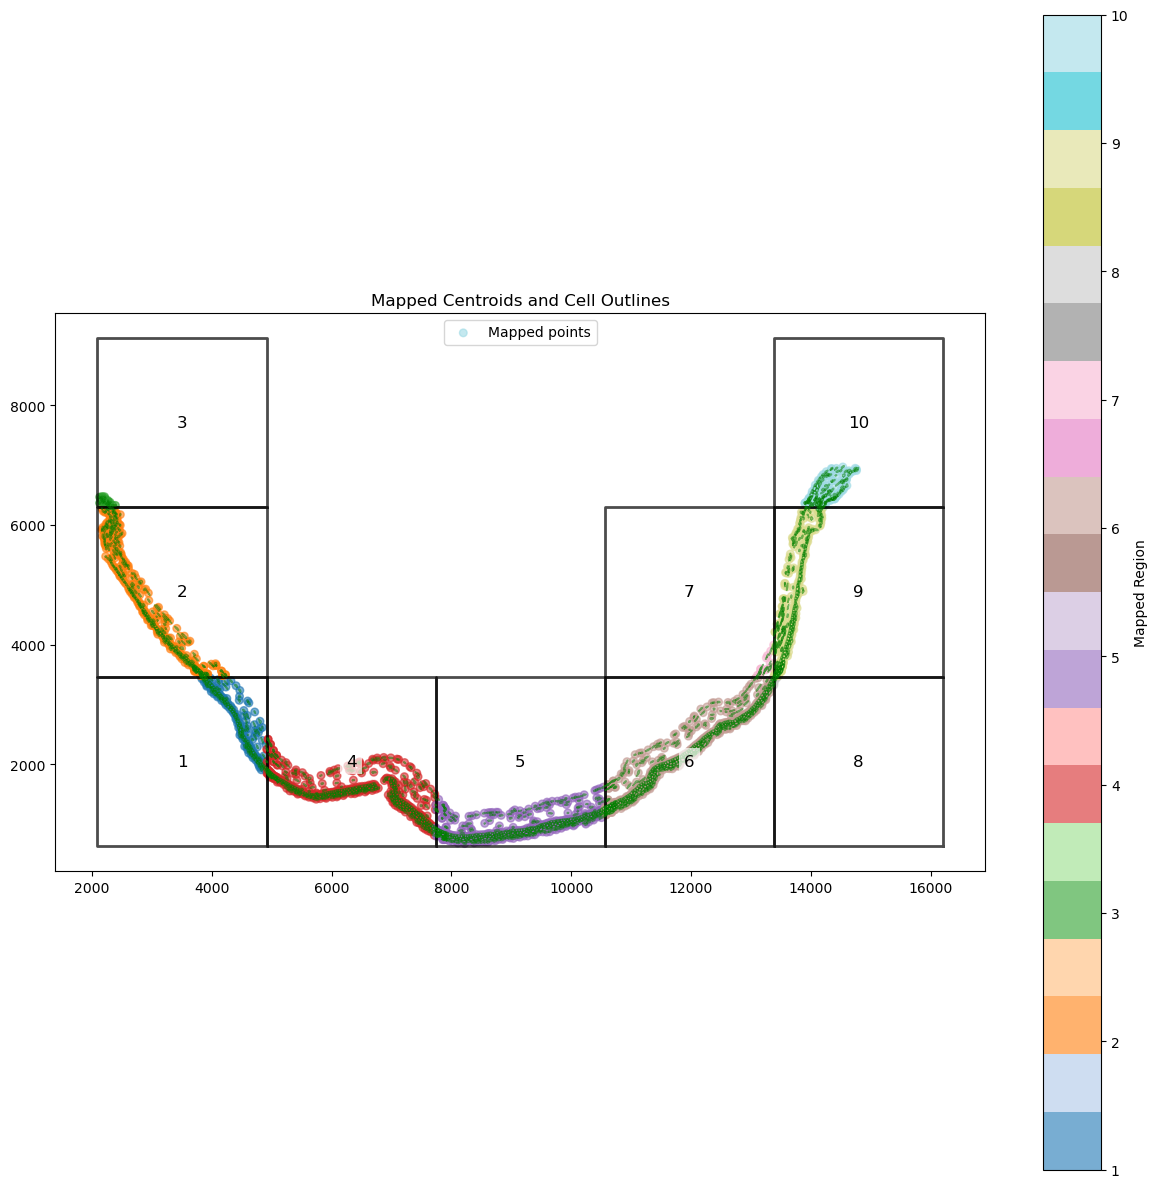


Results saved to: D:\Alexis\Projects\SpatialOmics_cellpose\results/segmenatation/1886od


In [17]:
# 4. Visualize results
visualize_mapped_data(mapped_df, outside_df, filtered_outlines_list, non_overlapping_squares)

# 5. Save results
output_dir = input_dir
mapped_df.to_csv(os.path.join(output_dir, 'mapped_centroids.csv'), index=False)
if not outside_df.empty:
    outside_df.to_csv(os.path.join(output_dir, 'unmapped_centroids.csv'), index=False)
outline_info.to_csv(os.path.join(output_dir, 'outline_mapping.csv'), index=False)
print(f"\nResults saved to: {output_dir}")

In [18]:
# Function to map segmentation outlines back to original coordinates
def map_to_original_coordinates(outlines, offset):

    min_x, min_y = offset
    
    return [outline + np.array([min_x, min_y]) for outline in outlines]

outlines_list = []


# Example processing loop for 3 cropped regions
for i, square in enumerate(overlapping_squares):
    
    # Stop the loop when i = 30 if 6 picture, set i + 1 = 5
    if i + 1 == 29:
        i1 = i + 1
        print("Reached the stopping condition: number = {i1}. Exiting the loop.")
        break

    print(f"Processing square {i + 1}: {square}")
    
    # Get bounding box of the current polygon (cropped region)
    min_x, min_y, max_x, max_y = map(int, square.bounds)

    # Load the segmentation result for the cropped region
    # segmentation_file = f"{ddir}/segmenatation/{sample_name}/cropped_square_com_{i + 1}_seg.npy"
    segmentation_file = f"{ddir}/segmenatation/{sample_name}/cropped_square_com_{i + 1}_seg.npy"
    segmentation_data = np.load(segmentation_file, allow_pickle=True).item()
    
    # Extract outlines from    the segmentation
    outlines = utils.outlines_list(segmentation_data['masks'])

    # Map outlines back to original coordinates
    mapped_outlines = map_to_original_coordinates(outlines, (min_x, min_y))
    outlines_list.extend(mapped_outlines)

Processing square 1: POLYGON ((5103.235294117647 645, 5103.235294117647 3656.235294117647, 2092 3656.235294117647, 2092 645, 5103.235294117647 645))
Processing square 2: POLYGON ((5103.235294117647 3468, 5103.235294117647 6479.235294117647, 2092 6479.235294117647, 2092 3468, 5103.235294117647 3468))
Processing square 3: POLYGON ((5103.235294117647 6291, 5103.235294117647 9302.235294117647, 2092 9302.235294117647, 2092 6291, 5103.235294117647 6291))
Processing square 4: POLYGON ((7926.235294117647 645, 7926.235294117647 3656.235294117647, 4915 3656.235294117647, 4915 645, 7926.235294117647 645))
Processing square 5: POLYGON ((10749.235294117647 645, 10749.235294117647 3656.235294117647, 7738 3656.235294117647, 7738 645, 10749.235294117647 645))
Processing square 6: POLYGON ((13572.235294117647 645, 13572.235294117647 3656.235294117647, 10561 3656.235294117647, 10561 645, 13572.235294117647 645))
Processing square 7: POLYGON ((13572.235294117647 3468, 13572.235294117647 6479.235294117647

In [ ]:
 # reuse previous function

In [25]:
df_outlines_list = boundaries_to_table(outlines_list)

import pandas as pd

def close_cell_boundaries(df):
    closed_df = []

    for cell_id, group in df.groupby('cell_id'):
        group_closed = pd.concat([group, group.iloc[[0]]])  # Append first row at end
        closed_df.append(group_closed)

    return pd.concat(closed_df).reset_index(drop=True)

df_outlines_list = close_cell_boundaries(df_outlines_list)



In [26]:
df_outlines_list.to_csv(f"{ddir}/segmenatation/{sample_name}/cellpose_cell_boundaries_origian_{sample_name}.csv", index=False)
print("Saved successly" )

Saved successly


In [27]:
# Apply the function
reduced_outlines_list = reduce_points(df_outlines_list)

# Print the results
print("Original shape:", df_outlines_list.shape)
print("Reduced shape:", reduced_outlines_list.shape)

Original shape: (267405, 3)
Reduced shape: (170784, 3)


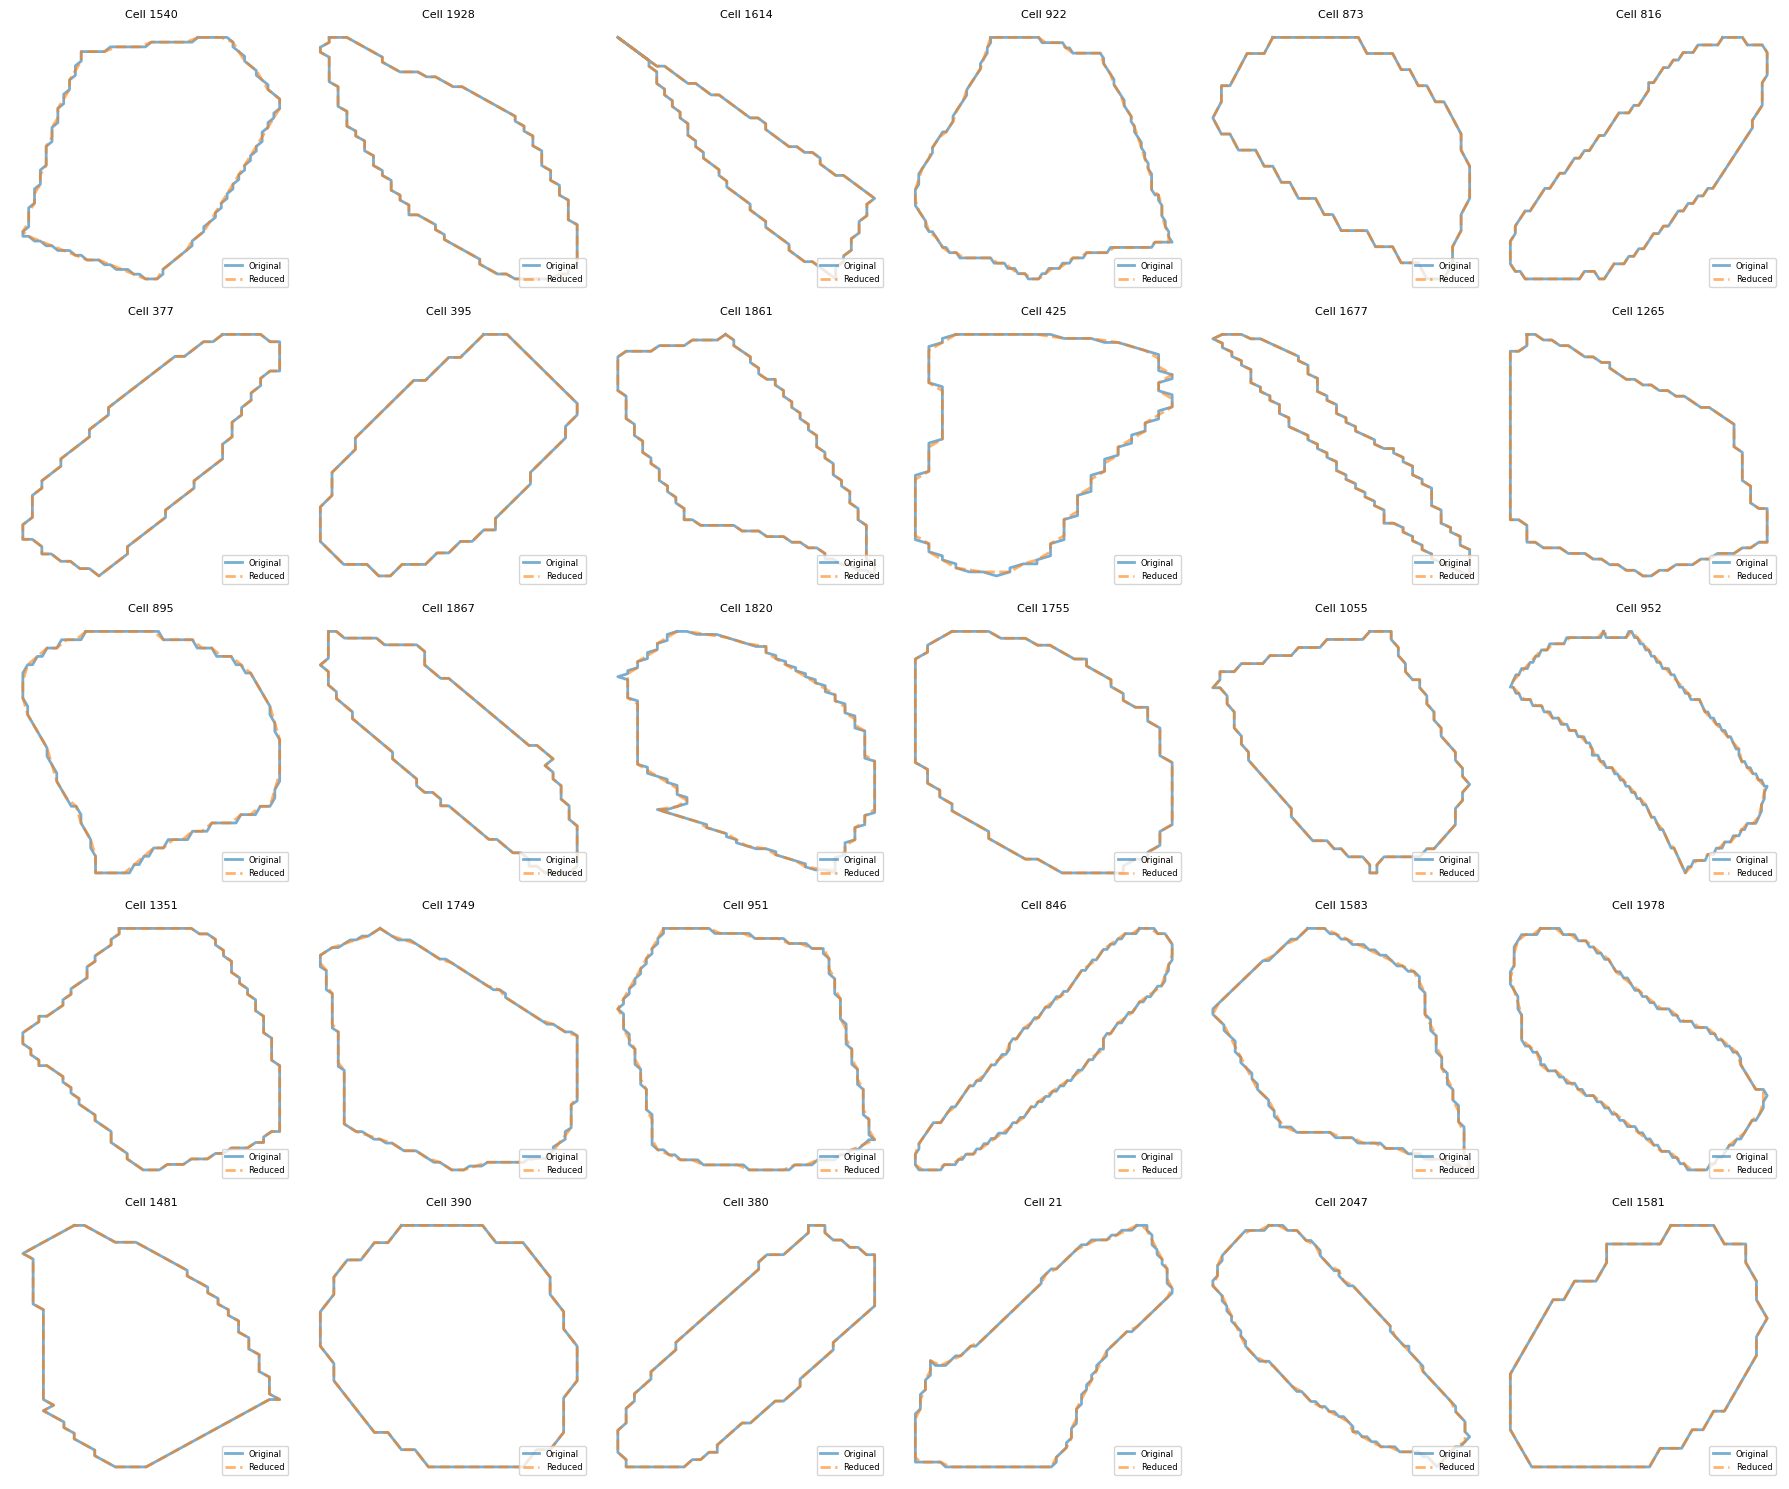

In [37]:
import matplotlib.pyplot as plt
import numpy as np

def plot_cell_outlines_comparison(df_orig, df_reduced, n=30, rows=5, cols=6):
    # find cell IDs present in both dataframes
    common_ids = np.intersect1d(df_orig['cell_id'].unique(),
                                df_reduced['cell_id'].unique())
    # sample up to n cells
    ids = np.random.choice(common_ids, min(n, len(common_ids)), replace=False)

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))
    axes = axes.flatten()
    for ax, cell_id in zip(axes, ids):
        orig = df_orig[df_orig['cell_id'] == cell_id]
        red  = df_reduced[df_reduced['cell_id'] == cell_id]

        # original outline
        ax.plot(orig['vertex_x'], orig['vertex_y'],
                linewidth=2, label='Original', alpha=0.6)
        # reduced outline
        ax.plot(red['vertex_x'],  red['vertex_y'],
                linewidth=2, linestyle='--', label='Reduced', alpha=0.6)

        ax.set_title(f'Cell {cell_id}', fontsize=8)
        ax.invert_yaxis()
        ax.axis('off')
        ax.legend(loc='lower right', fontsize=6)

    # turn off any extra axes
    for ax in axes[len(ids):]:
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# usage
plot_cell_outlines_comparison(df_outlines_list, reduced_outlines_list)



In [38]:
reduced_outlines_list.to_csv(f'{ddir}/segmenatation/{sample_name}/cellpose_cell_boundaries_{sample_name}.csv', index=False)
print("Saved successly" )

Saved successly


In [40]:
unique_cell_count = reduced_outlines_list['cell_id'].nunique()
# unique_cell_count = boundary_df['cell_id'].nunique()

unique_cell_count

2059

In [41]:
# Calculate centroids for each cell
centroids_df = calculate_centroids(reduced_outlines_list)
centroids_df

,cell_id,centroid_x,centroid_y
0,1,5094.636364,1704.181818
1,2,5092.446602,1735.106796
2,3,5065.152778,1764.555556
3,4,5034.235294,1763.632353
4,5,5097.800000,1762.716667
...,...,...,...
2054,2055,14343.592920,6939.920354
2055,2056,14352.934066,6930.868132
2056,2057,14423.803030,6940.772727
2057,2058,14742.086538,6944.817308


In [42]:
centroids_df_scaled = centroids_df.copy()
rescale_factor = 0.2125
centroids_df_scaled['centroid_x'] *= rescale_factor
centroids_df_scaled['centroid_y'] *= rescale_factor

In [43]:
centroids_df_scaled.to_csv(f'{ddir}/segmenatation/{sample_name}/cellpose_cell_centroids_{sample_name}.csv', index=False)
print("Saved successly" )

Saved successly


In [44]:
# Process to append the first row of each cell group
Outlines_list_final = (
    reduced_outlines_list.groupby('cell_id', group_keys=False)
    .apply(lambda group: pd.concat([group, group.iloc[[0]]], ignore_index=True))
)

Outlines_list_final

C:\Users\Alexis\AppData\Local\Temp\ipykernel_28376\3904916442.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda group: pd.concat([group, group.iloc[[0]]], ignore_index=True))


,cell_id,vertex_x,vertex_y
0,1,5099,1694
1,1,5098,1695
2,1,5097,1696
3,1,5096,1696
4,1,5095,1696
...,...,...,...
59,2059,14525,6944
60,2059,14523,6943
61,2059,14521,6942
62,2059,14519,6942


In [45]:
Outlines_list_final_scaled = Outlines_list_final.copy()
rescale_factor = 0.2125
Outlines_list_final_scaled['vertex_x'] *= rescale_factor
Outlines_list_final_scaled['vertex_y'] *= rescale_factor

In [46]:
Outlines_list_final.to_csv(f'{ddir}/segmenatation/{sample_name}/cellpose_cell_boundaries_pixel_{sample_name}.csv', index=False)
print("Saved successly" )

Saved successly


In [47]:
Outlines_list_final_scaled.to_csv(f'{ddir}/segmenatation/{sample_name}/cellpose_cell_boundaries_{sample_name}.csv', index=False)
print("Saved successly" )

Saved successly


## Assign Transcripts

In [48]:
from SRC_RESEG.assign_transcripts import *

In [49]:
import pandas as pd
boundaries_df_origin = pd.read_csv(f'{ddir}/segmenatation/{sample_name}/cellpose_cell_boundaries_{sample_name}.csv')
print("Data boundaries table file successfully")

boundaries_df_origin

Data boundaries table file successfully


,cell_id,vertex_x,vertex_y
0,1,1083.5375,359.9750
1,1,1083.3250,360.1875
2,1,1083.1125,360.4000
3,1,1082.9000,360.4000
4,1,1082.6875,360.4000
...,...,...,...
172838,2059,3086.5625,1475.6000
172839,2059,3086.1375,1475.3875
172840,2059,3085.7125,1475.1750
172841,2059,3085.2875,1475.1750


In [50]:
boundaries_df = boundaries_df_origin

In [51]:
transcripts_original = pd.read_parquet(f'{base_path}/transcripts.parquet')

# Print information about the data frame
transcripts_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27037577 entries, 0 to 27037576
Data columns (total 13 columns):
 #   Column             Dtype  
---  ------             -----  
 0   transcript_id      uint64 
 1   cell_id            object 
 2   overlaps_nucleus   uint8  
 3   feature_name       object 
 4   x_location         float32
 5   y_location         float32
 6   z_location         float32
 7   qv                 float32
 8   fov_name           object 
 9   nucleus_distance   float32
 10  codeword_index     int32  
 11  codeword_category  object 
 12  is_gene            bool   
dtypes: bool(1), float32(5), int32(1), object(4), uint64(1), uint8(1)
memory usage: 1.7+ GB


In [ ]:
# Filter transcripts with qv score > 20
transcripts_b4_assign = transcripts_original[transcripts_original['qv'] > 20]

# Print information about the filtered dataframe
print("Original number of transcripts:", len(transcripts_original))
print("Number of transcripts after filtering (qv > 20):", len(transcripts_b4_assign))
print("\nPercentage of transcripts retained:", 
      round(len(transcripts_b4_assign) / len(transcripts_original) * 100, 2), "%")

# Display first few rows of filtered dataframe
print("\nFirst few rows of filtered data:")
print(transcripts_b4_assign.head())

Original number of transcripts: 27037577
Number of transcripts after filtering (qv > 20): 22483362

Percentage of transcripts retained: 83.16 %

First few rows of filtered data:
     transcript_id     cell_id  overlaps_nucleus feature_name  x_location  \
0  281492156721341  UNASSIGNED                 0        Cetn3  149.375000   
1  281492156805561  UNASSIGNED                 0         Gpi1  144.765625   
2  281492156702271  UNASSIGNED                 0         Pfkl   45.265625   
3  281492156656058  UNASSIGNED                 0       Stxbp1   66.875000   
7  281492156884735  UNASSIGNED                 0        Acaca   26.703125   

   y_location  z_location     qv fov_name  nucleus_distance  codeword_index  \
0  736.390625   11.437500  27.25       C3        508.031250            9242   
1  734.609375   11.515625  28.25       C3        512.734375           17334   
2  731.937500   11.437500  28.50       C3        594.953125            6059   
3  747.296875   11.437500  26.75       C3  

In [55]:
processed_count = 0


In [73]:
import pandas as pd
from shapely.geometry import Point, Polygon
from shapely.prepared import prep

# 1) Load your polygon
polygon_coords = pd.read_csv(f"{base_path}/{sample_name}_coords.csv")
polygon = Polygon(zip(polygon_coords['X'], polygon_coords['Y']))

# 2) Build the bounding‐box filter
minx, miny, maxx, maxy = polygon.bounds

# 3) Prepare the polygon for fast repeated contains() checks
prepared_poly = prep(polygon)

# 4) Load transcripts
df = transcripts_b4_assign.copy()

# 5) First, prefilter by bbox (very cheap)
mask_bbox = (
    (df["x_location"] >= minx) &
    (df["x_location"] <= maxx) &
    (df["y_location"] >= miny) &
    (df["y_location"] <= maxy)
)
df_bbox = df[mask_bbox]

print(f"{len(df_bbox)} of {len(df)} points lie in the bbox, now doing exact test…")

# 6) Now do the exact point-in-polygon test with a simple list comprehension
from tqdm import tqdm
filtered = []
for x, y in tqdm(zip(df_bbox["x_location"], df_bbox["y_location"]),
                 total=len(df_bbox)):
    pt = Point(x, y)
    if prepared_poly.contains(pt):
        filtered.append(True)
    else:
        filtered.append(False)

transcripts_filtered = df_bbox[filtered]
print(f"Kept {len(transcripts_filtered)} points inside the actual polygon.")


3385687 of 22483362 points lie in the bbox, now doing exact test…


100%|██████████| 3385687/3385687 [01:23<00:00, 40399.76it/s]


Kept 2439389 points inside the actual polygon.


In [72]:
# # Slow
import pandas as pd
from shapely.geometry import Point, Polygon

# Load the polygon coordinates from CSV
polygon_coords_csv = f'{base_path}/{sample_name}_coords.csv'
polygon_coords = pd.read_csv(polygon_coords_csv)

# Extract the X and Y coordinates and create a polygon
x_coords = polygon_coords['X']
y_coords = polygon_coords['Y']
polygon = Polygon(zip(x_coords, y_coords))

# Load the transcripts data
transcripts_b4_cut = transcripts_b4_assign


# Initialize a counter
processed_count = 0

# Filter transcripts to retain only those within the polygon
def is_inside_polygon(row):
    global processed_count
    point = Point(row["x_location"], row["y_location"])
    processed_count += 1
    if processed_count % 100000 == 0:  # Print every 100 rows processed
        print(f"Processed {processed_count} transcripts...")
    return polygon.contains(point)

transcripts_filtered = transcripts_b4_cut[
    transcripts_b4_cut.apply(is_inside_polygon, axis=1)]



Processed 10000 transcripts...
Processed 20000 transcripts...
Processed 30000 transcripts...
Processed 40000 transcripts...
Processed 50000 transcripts...
Processed 60000 transcripts...
Processed 70000 transcripts...
Processed 80000 transcripts...


KeyboardInterrupt: 

In [63]:
transcripts_assigned = transcripts_filtered
transcripts_assigned

,transcript_id,cell_id,overlaps_nucleus,feature_name,x_location,y_location,z_location,qv,fov_name,nucleus_distance,codeword_index,codeword_category,is_gene
0,281492156721341,UNASSIGNED,0,Cetn3,149.375000,736.390625,11.437500,27.25,C3,508.031250,9242,predesigned_gene,True
1,281492156805561,UNASSIGNED,0,Gpi1,144.765625,734.609375,11.515625,28.25,C3,512.734375,17334,predesigned_gene,True
2,281492156702271,UNASSIGNED,0,Pfkl,45.265625,731.937500,11.437500,28.50,C3,594.953125,6059,predesigned_gene,True
3,281492156656058,UNASSIGNED,0,Stxbp1,66.875000,747.296875,11.437500,26.75,C3,568.468750,3935,predesigned_gene,True
7,281492156884735,UNASSIGNED,0,Acaca,26.703125,909.640625,11.781250,30.75,C3,515.312500,2638,predesigned_gene,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
27037569,281560876422978,UNASSIGNED,0,Snap25,3620.671875,2808.390625,12.421875,40.00,E8,195.703125,4991,predesigned_gene,True
27037570,281560876422980,UNASSIGNED,0,Snap25,3621.203125,2844.187500,12.453125,40.00,E8,231.437500,4991,predesigned_gene,True
27037571,281560876325944,UNASSIGNED,0,Trpm1,3539.609375,2850.812500,12.718750,40.00,E8,246.000000,999,predesigned_gene,True
27037572,281560876612025,UNASSIGNED,0,Yars,3563.578125,2786.859375,12.625000,40.00,E8,178.125000,2827,predesigned_gene,True


In [69]:
import pandas as pd
from shapely.geometry import Point, Polygon
from rtree import index

# Create R-Tree spatial index and polygons
spatial_index = index.Index()
cell_polygons = {}

for cell_id, group in Outlines_list_final_scaled.groupby("cell_id"):
    polygon = Polygon(zip(group["vertex_x"], group["vertex_y"]))
    cell_polygons[cell_id] = polygon
    spatial_index.insert(cell_id, polygon.bounds)

# Initialize a counter
processed_count = 0

# Optimized function to find the cell_id for a given x, y location
def find_cell_id_optimized(x, y):
    global processed_count
    point = Point(x, y)
    possible_matches = list(spatial_index.intersection((x, y, x, y)))
    for cell_id in possible_matches:
        if cell_polygons[cell_id].contains(point):
            return cell_id
    return "UNASSIGNED"

# Modified function to handle progress tracking with R-Tree
def process_with_progress(transcripts_df):
    global processed_count
    results = []
    for index, row in transcripts_df.iterrows():
        cell_id = find_cell_id_optimized(row["x_location"], row["y_location"])
        results.append(cell_id)
        processed_count += 1
        if processed_count % 100000   == 0:  # Print every 1000 rows processed
            print(f"Processed {processed_count} transcripts...")
    return results

# Assign cell_id with progress tracking
transcripts_assigned["cell_id"] = process_with_progress(transcripts_assigned)

print("Processing complete!")



Processed 10000 transcripts...
Processed 20000 transcripts...
Processed 30000 transcripts...
Processed 40000 transcripts...
Processed 50000 transcripts...
Processed 60000 transcripts...
Processed 70000 transcripts...
Processed 80000 transcripts...
Processed 90000 transcripts...
Processed 100000 transcripts...
Processed 110000 transcripts...
Processed 120000 transcripts...
Processed 130000 transcripts...
Processed 140000 transcripts...
Processed 150000 transcripts...
Processed 160000 transcripts...
Processed 170000 transcripts...
Processed 180000 transcripts...
Processed 190000 transcripts...
Processed 200000 transcripts...
Processed 210000 transcripts...
Processed 220000 transcripts...
Processed 230000 transcripts...
Processed 240000 transcripts...
Processed 250000 transcripts...
Processed 260000 transcripts...
Processed 270000 transcripts...
Processed 280000 transcripts...
Processed 290000 transcripts...
Processed 300000 transcripts...
Processed 310000 transcripts...
Processed 320000 

KeyboardInterrupt: 

In [ ]:
transcripts_assigned

In [ ]:
transcripts_assigned_ture = transcripts_assigned[transcripts_assigned["cell_id"] != "UNASSIGNED"]
transcripts_assigned_ture

In [ ]:
# Filter rows where cell_id is not "UNASSIGNED"
transcripts_assigned_ture = transcripts_assigned[transcripts_assigned["cell_id"] != "UNASSIGNED"]

# Display the result
transcripts_assigned_ture
  

In [ ]:
import pandas as pd
import os

def create_folder_if_not_exists(path):
    """Create folder if it doesn't exist."""
    if not os.path.exists(path):
        os.makedirs(path)
        print(f"Created directory: {path}")

output_dir = f"{ddir}/gene_expression_matrix/{sample_name}"
create_folder_if_not_exists(output_dir)

In [ ]:
# Assuming transcripts_assigned_ture is your DataFrame
output_path = f"{ddir}/gene_expression_matrix/{sample_name}/transcripts_assigned_ture.parquet"

# Save the DataFrame as a Parquet file
transcripts_assigned_ture.to_parquet(output_path, engine='pyarrow', index=False)

print(f"DataFrame saved successfully to {output_path}")

In [ ]:
centroids = pd.read_csv(f'{ddir}/segmenatation/{sample_name}/cellpose_cell_centroids_{sample_name}.csv')
print("Data centroids table file successfully")

In [ ]:
transcripts_data = transcripts_assigned_ture

# Create a pivot table for the gene expression matrix
gene_expression_matrix = (
    transcripts_data.groupby(["cell_id", "feature_name"])
    .size()
    .unstack(fill_value=0)
    .reset_index()
)

# Add total counts column

gene_expression_matrix["Total Counts"] = gene_expression_matrix.drop(columns=["cell_id"]).sum(axis=1)

# Merge with centroids to add centroid coordinates
gene_expression_matrix = pd.merge(
    gene_expression_matrix,
    centroids_df,
    how="left",
    on="cell_id")

In [ ]:
gene_expression_matrix

In [ ]:
later_columns = gene_expression_matrix.columns[1:]

In [ ]:
# Fill empty values with 0 for all columns after column 4
gene_expression_matrix[later_columns] = gene_expression_matrix[later_columns].fillna(0)

# Verify the changes
print("\nChecking if there are still any empty values:")
print(gene_expression_matrix[later_columns].isna().sum())

# Display a few rows to verify the changes
print("\nFirst few rows after filling empty values:")
print(gene_expression_matrix.head())

In [ ]:
import pandas as pd

# Assuming transcripts_assigned_ture is your DataFrame
output_path = rf"{ddir}/gene_expression_matrix/{sample_name}/{sample_name}_gene_expression_matrix.csv"

# Save the DataFrame as a Parquet file
gene_expression_matrix.to_csv(output_path, index=False)

print(f"DataFrame saved successfully to {output_path}")